# Prever Performance Estudantil

O **Índice de Desempenho Acadêmico (IDA)** quantifica a proficiência do aluno nos exames padronizados de avaliação interna das disciplinas oferecidas pela Associação Passos Mágicos, aos alunos das Fases 0 a 7. Para os alunos da Fase 8, o indicador registra a nota média obtida pelos alunos em todas as disciplinas cursadas, nas respectivas instituições de ensino superior conveniadas ao programa de bolsas de estudo.

O objetivo é desenvolver um modelo de Machine Learning, utilizando Redes Neurais, para prever a performance acadêmica dos alunos entre as *fases 0 e 7*. Identificar os alunos com maior risco de baixo desempenho acadêmico permite com que a Associação Passos Mágicos possa se antecipar a um sentimento de frustração, que pode levar à desistência do aluno.

# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

pd.set_option('display.max_columns', None)

In [2]:
# Pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Avaliação do modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Salvar modelo
import pickle

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# Otimização de hiperparâmetros
import keras_tuner

# Visualização de modelos
import visualkeras

# Versão do TensorFlow
print(tf.__version__)

2.17.0


# Pré-processamento dos Dados

In [3]:
df = pd.read_csv('data\cleaned\df_all.csv')

df

,nome,instituicao_ensino_aluno,idade_aluno,anos_pm,ponto_virada,inde,inde_conceito,pedra,destaque_ieg,destaque_ida,destaque_ipv,iaa,ieg,ips,ida,ipp,ipv,ian,ano,fase,turma,sinalizador_ingressante,rec_equipe_1,rec_equipe_2,rec_equipe_3,rec_equipe_4,nivel_ideal,defasagem,ano_ingresso,bolsista,cg,cf,ct,nota_port,nota_mat,nota_ing,qtd_aval,rec_ava_1,rec_ava_2,rec_ava_3,rec_ava_4,indicado_bolsa,grupo_fase,saiu,atencao,destaque
0,ALUNO-1,Escola Pública,11.0,2.0,False,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.50002,8.700000,7.500,7.000000,5.93750,7.750000,10.0,2020,2,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
1,ALUNO-3,Escola Pública,12.0,2.0,False,7.856390,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,7.91667,8.900000,7.500,5.500000,8.12500,8.111113,10.0,2020,3,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
2,ALUNO-4,Escola Pública,10.0,2.0,False,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.00002,4.100000,6.875,0.000000,7.18750,7.750000,5.0,2020,1,D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,True,False,False
3,ALUNO-5,Escola Pública,10.0,1.0,False,8.077085,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integração aos...,7.50002,8.000000,7.500,7.500000,8.43750,8.166665,10.0,2020,2,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
4,ALUNO-8,Rede Decisão/União,14.0,3.0,True,8.381391,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integração aos...,8.33334,9.900000,4.375,7.333333,8.75000,8.944450,10.0,2020,4,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fases 1-7,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2270,ALUNO-1342,NaN,NaN,NaN,False,8.150001,NaN,Topázio,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,7.91668,9.666667,7.500,7.750000,6.25000,7.500000,10.0,2022,2,K,NaN,NaN,NaN,NaN,NaN,Fase 2 (5º e 6º ano),NaN,2022.0,False,99.0,13.0,1.0,6.000000,9.500000,NaN,3.0,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,False,Fases 1-7,False,False,False
2271,ALUNO-1343,NaN,NaN,NaN,False,5.674644,NaN,Quartzo,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,7.41668,6.470435,6.250,2.000000,6.25000,7.444443,5.0,2022,2,K,NaN,NaN,NaN,NaN,NaN,Fase 4 (9º ano),NaN,2018.0,False,763.0,141.0,11.0,2.000000,2.000000,NaN,3.0,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,False,Fases 1-7,False,False,False
2272,ALUNO-1346,NaN,NaN,NaN,True,8.135538,NaN,Topázio,Destaque: A sua boa entrega das lições de casa.,Destaque: As suas boas notas na Passos Mágicos.,Destaque: A sua boa integração aos Princípios ...,9.00002,9.031839,7.500,9.000000,5.62500,9.083340,5.0,2022,0,U,NaN,NaN,NaN,NaN,NaN,Fase 1 (4º ano),NaN,2022.0,False,105.0,30.0,2.0,9.166667,8.833333,NaN,2.0,Promovido de Fase,Promovido de Fase,NaN,NaN,False,Fases 1-7,False,False,False
2273,ALUNO-1348,NaN,NaN,NaN,False,6.749981,NaN,Ágata,Destaque: A sua boa entrega das lições de cas

In [4]:
df = identify_outliers(df)

Alunos da fase 8 têm avaliação de desempenho diferente da metodologia aplicada pela Passos Mágicos, uma vez que o desempenho acadêmico é calculado de acordo com as notas de cada Instituição. Além disso, o valor ZERO no IAN representa alunos que não realizaram a avaliação. Antes de seguir com o modelo, ambos os casos são removidos do dataset:

In [5]:
# Apenas IDA maior que zero e fase diferente de 8
df = df[(df['ida'] > 0) & (df['fase'] != 8)]

df.shape

(2160, 46)

In [6]:
# Coluna a ser prevista - IDA (Índice de Desempenho Acadêmico)
y_col = 'ida'

# Features - colunas importantes e sempre presentes nos datasets analisados
X_cols = ['fase', 'ponto_virada', 'ano', 'bolsista', 'iaa', 'ian', 'ieg', 'ips', 'ipp', 'ipv', 'atencao', 'destaque']

X = df[X_cols].copy()
y = df[y_col].copy()

# Verificando valores nulos
X.isna().sum().sum(), y.isna().sum()

(0, 0)

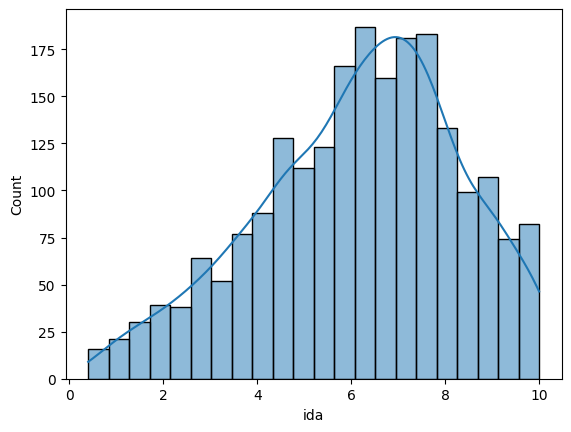

In [7]:
# Distribuição da variável alvo
sns.histplot(y, kde=True);

In [8]:
# Verificando os tipos
X.dtypes

fase              int64
ponto_virada       bool
ano               int64
bolsista           bool
iaa             float64
ian             float64
ieg             float64
ips             float64
ipp             float64
ipv             float64
atencao          object
destaque         object
dtype: object

In [9]:
# Ano e Fase são variáveis categóricos
X['ano'] = X['ano'].astype('object')
X['fase'] = X['fase'].astype('object')

In [10]:
# Separando as variáveis categóricas, booleanas e numéricas
cat_vars = X.select_dtypes(include=['object']).columns
bool_vars = X.select_dtypes(include=['bool']).columns
num_vars = X.select_dtypes(include=['int64', 'float64']).columns

cat_vars, bool_vars, num_vars

(Index(['fase', 'ano', 'atencao', 'destaque'], dtype='object'),
 Index(['ponto_virada', 'bolsista'], dtype='object'),
 Index(['iaa', 'ian', 'ieg', 'ips', 'ipp', 'ipv'], dtype='object'))

In [11]:
# Variáveis booleanas para numéricas
X[bool_vars] = X[bool_vars].astype(int)

A separação do dataset em treino, teste e validação é feita de forma estratificada pela coluna "ano", para que haja igual distribuição de alunos em cada conjunto. Por isso, a transformação de dados categóricos em numéricos é feita após a separação dos dados.

In [12]:
# Divisão dos dados em treino e teste
seed = 19
strat = 'ano'

# Divisão em treino e teste  - mesma quantidade de alunos por ano
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=X[strat])

# Divisão de dados em Validação - 0.25*0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed, stratify=X_train[strat])

print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

X_train: (1296, 12)
X_val: (432, 12)
X_test: (432, 12)


In [13]:
# Normalização - MinMax porque todos os números são positivos
scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_val[num_vars] = scaler.transform(X_val[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train.describe()

,ponto_virada,bolsista,iaa,ian,ieg,ips,ipp,ipv
count,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000
mean,0.151235,0.652778,0.831082,0.588992,0.766951,0.685965,0.700201,0.741971
std,0.358416,0.476271,0.197234,0.334442,0.199273,0.126480,0.138914,0.129261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.791668,0.333333,0.664011,0.625000,0.625000,0.680000
50%,0.000000,1.000000,0.880000,0.333333,0.820000,0.750000,0.734375,0.750000
75%,0.000000,1.000000,0.950000,1.000000,0.920000,0.750000,0.796875,0.825000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# Coluna Ano e Fase para One-Hot Encoding
X_train = pd.get_dummies(X_train, columns=['ano', 'fase'])
X_test = pd.get_dummies(X_test, columns=['ano', 'fase'])
X_val = pd.get_dummies(X_val, columns=['ano', 'fase'])
                       
X_train.shape, X_test.shape, X_val.shape

((1296, 21), (432, 21), (432, 21))

In [15]:
# Concatenar dados de treino e validação para retreinar o modelo
X_all = pd.concat([X_train, X_val])
y_all = pd.concat([y_train, y_val])

all_df = pd.concat([X_all, y_all], axis=1)

X_all.shape, y_all.shape

((1728, 21), (1728,))

In [16]:
# Garantir que X e y sejam tensores
X_train = tf.constant(X_train.values, dtype=tf.float32)
y_train = tf.constant(y_train.values, dtype=tf.float32)

X_val = tf.constant(X_val.values, dtype=tf.float32)
y_val = tf.constant(y_val.values, dtype=tf.float32)

X_test = tf.constant(X_test.values, dtype=tf.float32)
y_test = tf.constant(y_test.values, dtype=tf.float32)

X_all = tf.constant(X_all.values, dtype=tf.float32)
y_all = tf.constant(y_all.values, dtype=tf.float32)

# Modelo Baseline

In [17]:
# Apenas 1 neurônio de saída e nenhuma ativação não-linear, portanto, uma regressão linear
linear_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(1)
])

linear_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

linear_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Treinamento do modelo com dados normalizados
linear_history = linear_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.8294 - mae: 7.0827 - mse: 54.8294 - val_loss: 49.8882 - val_mae: 6.6843 - val_mse: 49.8882
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 48.2436 - mae: 6.5889 - mse: 48.2436 - val_loss: 45.6530 - val_mae: 6.3678 - val_mse: 45.6530
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 45.3806 - mae: 6.3810 - mse: 45.3806 - val_loss: 41.7138 - val_mae: 6.0595 - val_mse: 41.7138
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 41.1016 - mae: 6.0195 - mse: 41.1016 - val_loss: 38.0741 - val_mae: 5.7607 - val_mse: 38.0741
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 37.4519 - mae: 5.7147 - mse: 37.4519 - val_loss: 34.7110 - val_mae: 5.4718 - val_mse: 34.7110
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 34.6338 - mae: 5.4856 - mse: 34.6338 - val_loss: 31.5886 - val_mae: 5.1914 - val_mse: 31.5886
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 30.9116 - mae: 5.1

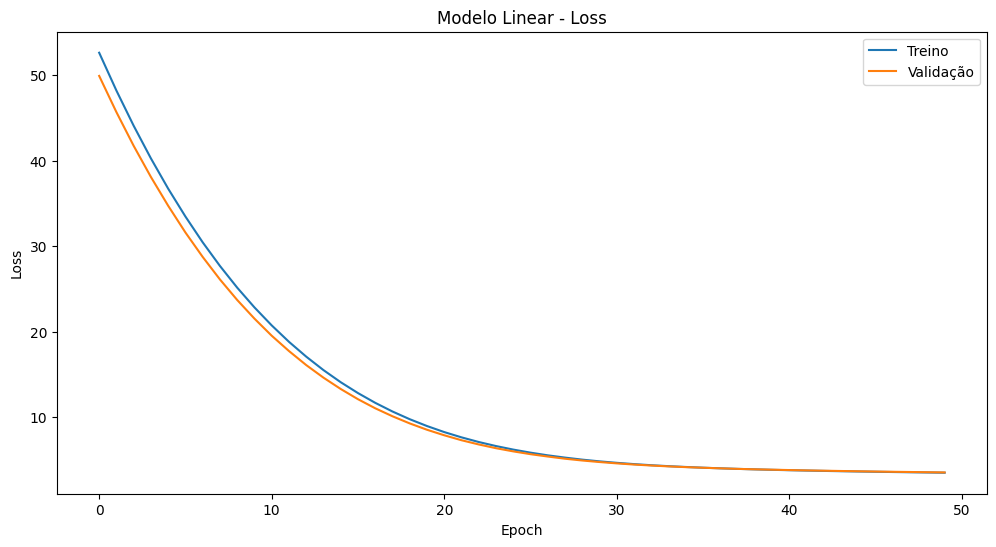

In [19]:
# Plotar função de custo
fig = plt.figure(figsize=(12, 6))
plt.plot(linear_history.history['loss'], label='Treino')
plt.plot(linear_history.history['val_loss'], label='Validação')
plt.title('Modelo Linear - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Avaliação
linear_model.evaluate(X_test, y_test)

# Previsões
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(np.array(y_test), y_pred_linear)
mae_linear = mean_absolute_error(np.array(y_test), y_pred_linear)
r2_linear = r2_score(np.array(y_test), y_pred_linear)

print('MSE:', mse_linear)
print('MAE:', mae_linear)
print('R2:', r2_linear)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 3.6085 - mae: 1.5341 - mse: 3.6085
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MSE: 3.6471815
MAE: 1.5359889
R2: 0.20273172855377197


O modelo parece não ter previsto abaixo de aproximadamente 3.69. Já o valor mínimo real é 0.4.

In [21]:
y_pred_linear.min(), np.array(y_test).min()

(3.8570814, 0.4)

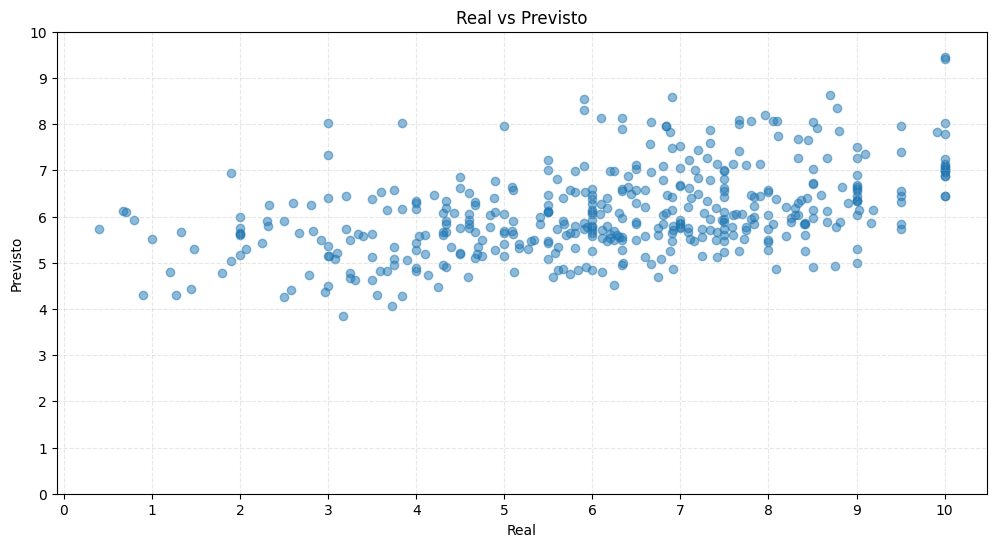

In [22]:
# Comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.show()

Criar um modelo baseline simples, adicionando 1 camada oculta de 64 neurônios e ativação ReLU, ao modelo anterior:

In [23]:
# Modelo Baseline 1 camada e ativação ReLU
base_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compilação
base_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Treinamento
base_history = base_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.7168 - mae: 5.5984 - mse: 35.7168 - val_loss: 19.3728 - val_mae: 3.9124 - val_mse: 19.3728
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.3624 - mae: 3.4442 - mse: 15.3624 - val_loss: 5.4055 - val_mae: 1.9327 - val_mse: 5.4055
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 4.5791 - mae: 1.7340 - mse: 4.5791 - val_loss: 3.7829 - val_mae: 1.5665 - val_mse: 3.7829
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.7339 - mae: 1.5551 - mse: 3.7339 - val_loss: 3.5115 - val_mae: 1.5146 - val_mse: 3.5115
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6483 - mae: 1.5273 - mse: 3.6483 - val_loss: 3.3221 - val_mae: 1.4727 - val_mse: 3.3221
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3.1210 - mae: 1.4146 - mse: 3.1210 - val_loss: 3.1914 - val_mae: 1.4485 - val_mse: 3.1914
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 3.0039 - mae: 1.4018 - mse: 3.0039 - val

A função de custo diminui rapidamente entre as épocas 0 e 10, mas a partir da época 10, a função de custo diminui mais lentamente. Isso sugere que o modelo está aprendendo rapidamente no início, mas depois começa a estagnar. Diminuir a taxa de aprendizado pode ajudar a melhorar o desempenho do modelo. No entanto, simplificar a rede neural, além de diminuir o número de épocas de treinamento é uma alternativa mais eficiente.

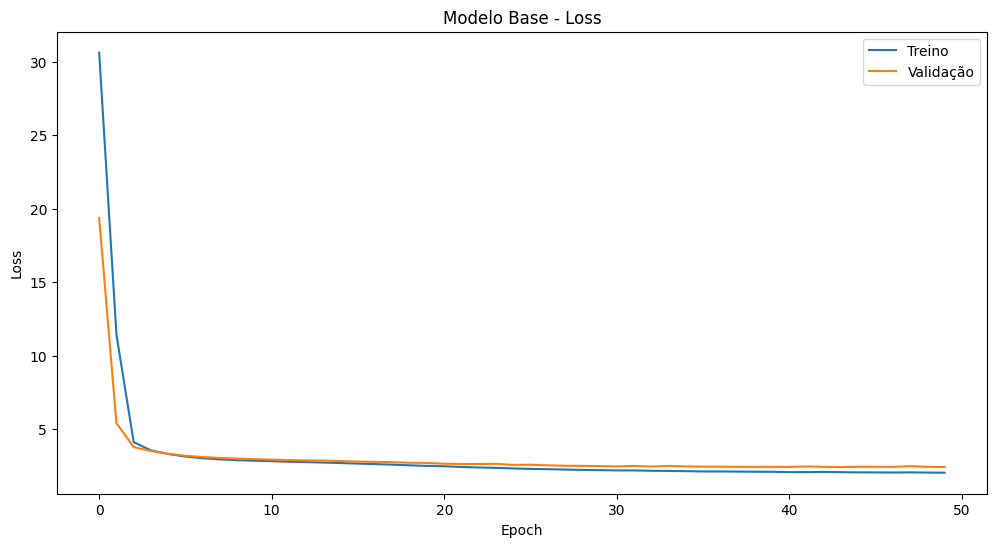

In [24]:
# Plotar função de custo
plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Treino')
plt.plot(base_history.history['val_loss'], label='Validação')
plt.title('Modelo Base - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Avaliação
base_model.evaluate(X_test, y_test)

# Previsões
y_pred_base = base_model.predict(X_test)

mse_base = mean_squared_error(np.array(y_test), y_pred_base)
mae_base = mean_absolute_error(np.array(y_test), y_pred_base)
r2_base = r2_score(np.array(y_test), y_pred_base)

print('MSE:', mse_base)
print('MAE:', mae_base)
print('R2:', r2_base)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 2.0790 - mae: 1.1234 - mse: 2.0790
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MSE: 2.0959444
MAE: 1.1200651
R2: 0.5418297052383423


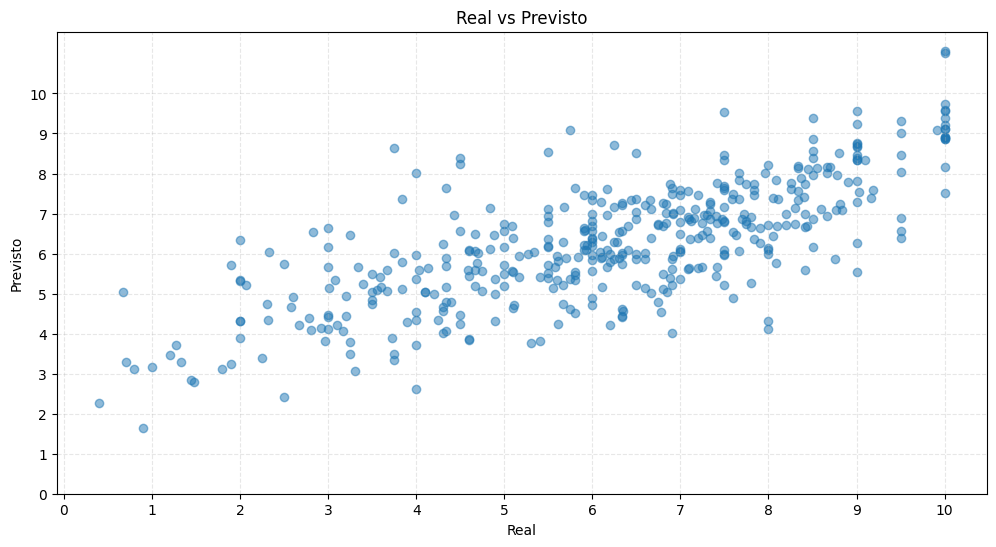

In [26]:
# Comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_base, alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.show()

Diminuir o número de épocas de treinamento, mantendo a mesma arquitetura da rede neural:

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40.7020 - mae: 6.0241 - mse: 40.7020 - val_loss: 23.5147 - val_mae: 4.3988 - val_mse: 23.5147
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 18.2094 - mae: 3.8008 - mse: 18.2094 - val_loss: 6.4776 - val_mae: 2.1702 - val_mse: 6.4776
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 5.1244 - mae: 1.8710 - mse: 5.1244 - val_loss: 3.6105 - val_mae: 1.5356 - val_mse: 3.6105
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 3.5510 - mae: 1.5114 - mse: 3.5510 - val_loss: 3.4309 - val_mae: 1.4966 - val_mse: 3.4309
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - loss: 3.1544 - mae: 1.4134 - mse: 3.1544 - val_loss: 3.3007 - val_mae: 1.4731 - val_mse: 3.3007
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 3.3273 - mae: 1.4402 - mse: 3.3273 - val_loss: 3.2121 - val_mae: 1.4526 - val_mse: 3.2121
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 3.1553 - mae: 1.4244 - mse: 3.1553 -

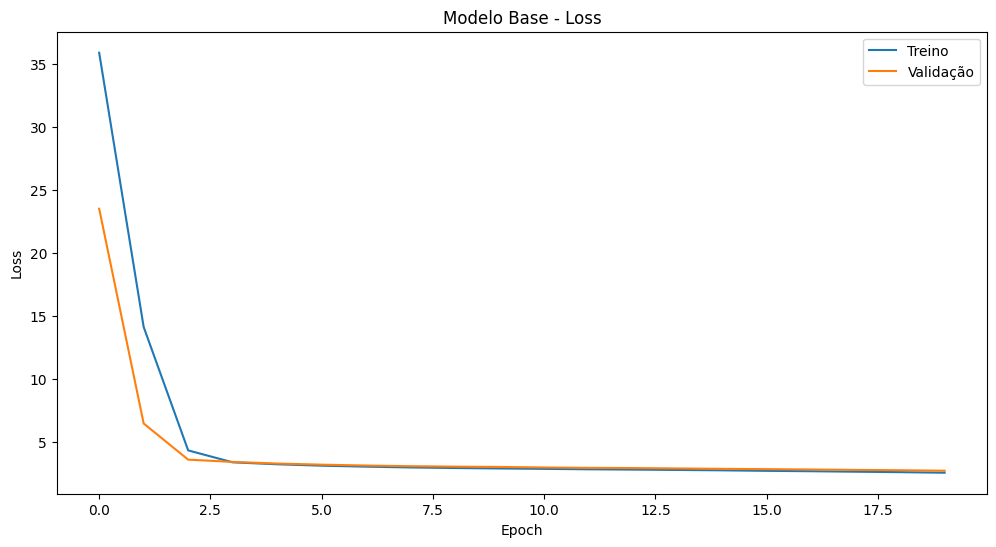

In [27]:
# Diminuir o número de épocas para 20, já que parece que o modelo começa a ter alta variância (overfitting)
base_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

base_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# 20 épocas
base_history = base_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Plotar função de custo
fig = plt.figure(figsize=(12, 6))
plt.plot(base_history.history['loss'], label='Treino')
plt.plot(base_history.history['val_loss'], label='Validação')
plt.title('Modelo Base - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Avaliação
base_model.evaluate(X_test, y_test)

# Previsões
y_pred_base = base_model.predict(X_test)

mse_base = mean_squared_error(np.array(y_test), y_pred_base)
mae_base = mean_absolute_error(np.array(y_test), y_pred_base)
r2_base = r2_score(np.array(y_test), y_pred_base)

print('MSE:', mse_base)
print('MAE:', mae_base)
print('R2:', r2_base)

Modelo com 32 neurônios e 20 épocas de treinamento:

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 44.1109 - mae: 6.2721 - mse: 44.1109 - val_loss: 34.3840 - val_mae: 5.4640 - val_mse: 34.3840
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 31.5514 - mae: 5.2189 - mse: 31.5514 - val_loss: 23.0594 - val_mae: 4.3619 - val_mse: 23.0594
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 20.3462 - mae: 4.0688 - mse: 20.3462 - val_loss: 12.1245 - val_mae: 3.0243 - val_mse: 12.1245
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 10.0516 - mae: 2.7398 - mse: 10.0516 - val_loss: 5.6246 - val_mae: 1.9963 - val_mse: 5.6246
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 4.6234 - mae: 1.7872 - mse: 4.6234 - val_loss: 3.7759 - val_mae: 1.5972 - val_mse: 3.7759
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - loss: 3.5647 - mae: 1.5396 - mse: 3.5647 - val_loss: 3.4868 - val_mae: 1.5154 - val_mse: 3.4868
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 3.5314 - mae: 1.5019 - mse: 

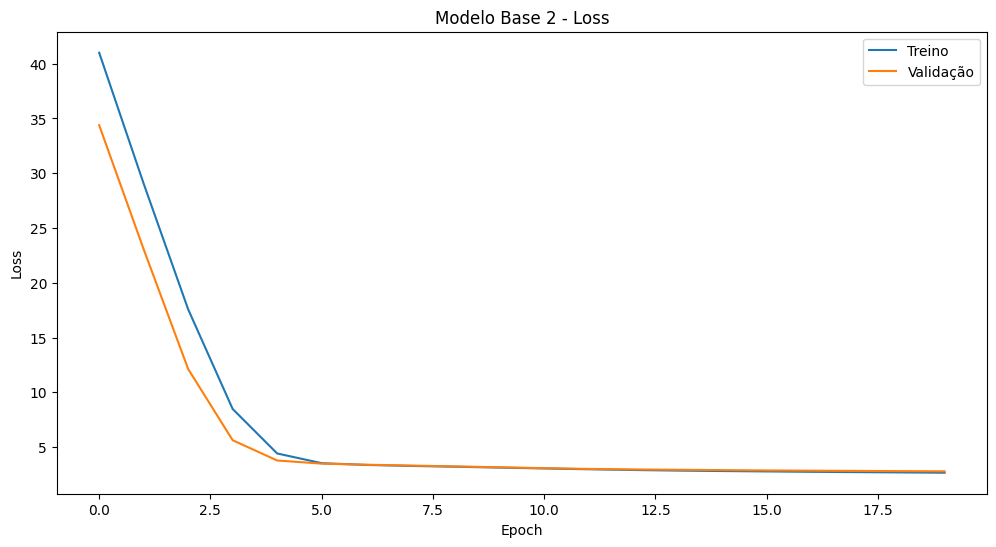

In [28]:
base_model_2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'), # Diminuir o número de neurônios
    Dense(1)
])

base_model_2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# 50 épocas
base_history_2 = base_model_2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Plotar função de custo
fig = plt.figure(figsize=(12, 6))
plt.plot(base_history_2.history['loss'], label='Treino')
plt.plot(base_history_2.history['val_loss'], label='Validação')
plt.title('Modelo Base 2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Avaliação
base_model_2.evaluate(X_test, y_test)

# Previsões
y_pred_base_2 = base_model_2.predict(X_test)

mse_base_2 = mean_squared_error(np.array(y_test), y_pred_base_2)
mae_base_2 = mean_absolute_error(np.array(y_test), y_pred_base_2)
r2_base_2 = r2_score(np.array(y_test), y_pred_base_2)

print('MSE:', mse_base_2)
print('MAE:', mae_base_2)
print('R2:', r2_base_2)

Por mais próximo da realidade que o modelo esteja (MAE=1.16 no modelo com 50 épocas de treinamento e MAE=1.27 no modelo com 20 épocas), ocorreu *overfitting*. Para evitar esse problema, pode-se aplicar algum tipo regularização, como L2 (Ridge) ou L1 (Lasso), ou até mesmo Dropout.

As regularizações L1 e L2 penalizam os pesos da rede, forçando-os a serem menores. A diferença entre elas é que a L1 penaliza os pesos de forma proporcional ao seu valor absoluto, enquanto a L2 penaliza os pesos de forma proporcional ao seu quadrado. A regularização L2 é mais comum, uma vez em que não zera os pesos, mas os deixa muito pequenos. O L1, por sua vez, zera os pesos, o que pode ser prejudicial para a rede. O Dropout é uma técnica que desativa aleatoriamente uma fração dos neurônios da rede, evitando que a rede se torne muito dependente de um único neurônio. 

As regularizações L1 e L2 são aplicadas diretamente na função de custo, enquanto o Dropout é aplicado na camada da rede.

In [29]:
# Modelo Baseline com 64 neurônios + Regularização L2
base_model_l2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(1)
])

base_model_l2.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# 20 épocas
base_history_l2 = base_model_l2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36.1943 - mae: 5.6187 - mse: 35.8850 - val_loss: 20.4066 - val_mae: 4.0459 - val_mse: 20.1049
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.2844 - mae: 3.5591 - mse: 15.9813 - val_loss: 5.8415 - val_mae: 1.9850 - val_mse: 5.5293
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 4.8185 - mae: 1.7557 - mse: 4.5038 - val_loss: 3.6913 - val_mae: 1.4921 - val_mse: 3.3764
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8809 - mae: 1.5134 - mse: 3.5689 - val_loss: 3.5242 - val_mae: 1.4652 - val_mse: 3.2199
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 3.2475 - mae: 1.3858 - mse: 2.9455 - val_loss: 3.3960 - val_mae: 1.4428 - val_mse: 3.0990
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 3.4579 - mae: 1.4153 - mse: 3.1617 - val_loss: 3.3280 - val_mae: 1.4254 - val_mse: 3.0362
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 3.0950 - mae: 1.3615 - mse: 2.8042 - val

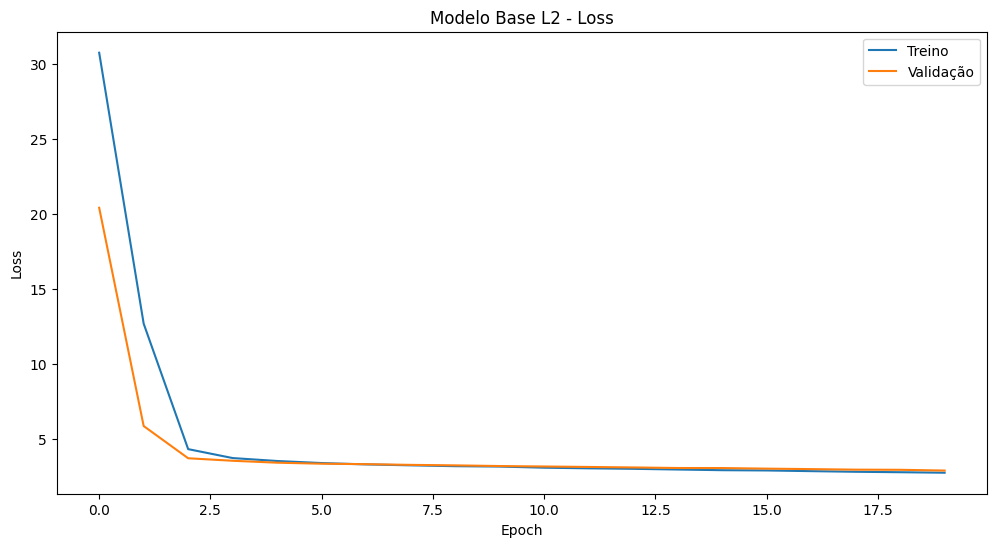

In [30]:
# Plotar função de custo
fig = plt.figure(figsize=(12, 6))
plt.plot(base_history_l2.history['loss'], label='Treino')
plt.plot(base_history_l2.history['val_loss'], label='Validação')
plt.title('Modelo Base L2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
# Avaliação
base_model_l2.evaluate(X_test, y_test)

# Previsões
y_pred_base_l2 = base_model_l2.predict(X_test)

mse_base_l2 = mean_squared_error(np.array(y_test), y_pred_base_l2)
mae_base_l2 = mean_absolute_error(np.array(y_test), y_pred_base_l2)
r2_base_l2 = r2_score(np.array(y_test), y_pred_base_l2)

print('MSE:', mse_base_l2)
print('MAE:', mae_base_l2)
print('R2:', r2_base_l2)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 2.6871 - mae: 1.2478 - mse: 2.4386
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
MSE: 2.504684
MAE: 1.2540468
R2: 0.4524799585342407


O modelo continua a apresentar *overfitting*. Para tentar resolver esse problema de forma eficaz, utiliza-se uma Random Search (Busca Aleatória), que permite testar diferentes combinações de hiperparâmetros, a fim de encontrar a melhor combinação para o modelo.

# Otimização de Hiperparâmetros

O **AutoML** (Aprendizado de Máquina Automático) é uma técnica que automatiza o processo de seleção de modelos e hiperparâmetros - técnicas de otimização e busca de hiperparâmetros incluem Grid Search, Random Search, Bayesian Optimization, Genetic Algorithms, Hyperband, entre outros. Essa é uma área de pesquisa ativa, parte do AutoML, que visa automatizar o processo de ajuste de hiperparâmetros.

In [32]:
import keras
from keras import layers
from keras import regularizers
import keras_tuner

# Modelo de regressão com hiperparâmetros ajustáveis
class HyperRegressionModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        for i in range(hp.Int("num_layers", 1, 5)):
            # Tipos de regularização L1, L2 e L1_L2
            reg_type = hp.Choice(f"reg_type_{i}", ["none", "l1", "l2", "l1_l2"])
            if reg_type == "l1":
                reg = regularizers.l1(l1=hp.Float(f"l1_reg_{i}", min_value=1e-5, max_value=1e-2, sampling="log"))
            elif reg_type == "l2":
                reg = regularizers.l2(l2=hp.Float(f"l2_reg_{i}", min_value=1e-5, max_value=1e-2, sampling="log"))
            elif reg_type == "l1_l2":
                reg = regularizers.l1_l2(l1=hp.Float(f"l1_reg_{i}", min_value=1e-5, max_value=1e-2, sampling="log"),
                                        l2=hp.Float(f"l2_reg_{i}", min_value=1e-5, max_value=1e-2, sampling="log"))
            else:
                reg = None

            model.add(
                layers.Dense(
                    # 16 a 512 neurônios, aumentando de 16 em 16
                    units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                    # 2 funções de ativação - ReLU e Tanh
                    activation=hp.Choice("activation", ["relu", "tanh"]),
                    kernel_regularizer=reg
                )
            )
        # Usar ou não dropout
        if hp.Boolean("dropout"):
            # Camada de dropout para regularização com taxa de 20%
            model.add(layers.Dropout(rate=0.20))
        # Camada de saída
        model.add(layers.Dense(1))
        # Taxa de aprendizado de 0.0001 a 0.01
        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        
        # Compilação do modelo
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss="mean_squared_error",
            metrics=["mean_squared_error", "mean_absolute_error"],
        )
        
        return model

    def fit(self, hp, model, x, y, **kwargs):
        # Número de épocas e tamanho do batch
        epochs = hp.Choice("epochs", values=[50, 100, 500])
        batch_size = hp.Choice("batch_size", values=[32, 64, 128])
        
        # Testando com e sem embaralhamento dos dados
        shuffle = hp.Boolean("shuffle")
        
        return model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=shuffle,
            **kwargs,
        )

In [33]:
seed = 19

# Random Search
tuner = keras_tuner.RandomSearch(
    hypermodel=HyperRegressionModel(),
    # Otimização da métrica de erro quadrático médio no conjunto de validação
    objective="val_mean_squared_error",
    # 5 tentativas e 5 execuções por tentativa
    max_trials=5,
    executions_per_trial=5,
    overwrite=True,
    seed=seed,
    directory="models",
    project_name="students_performance",
)

# Busca de hiperparâmetros
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

Trial 5 Complete [00h 00m 21s]
val_mean_squared_error: 2.3629354000091554

Best val_mean_squared_error So Far: 2.3466296672821043
Total elapsed time: 00h 07m 19s


In [34]:
# Melhores hiperparâmetros
hypermodel = HyperRegressionModel()
best_hp = tuner.get_best_hyperparameters()[0]
model = hypermodel.build(best_hp)

# Arquitetura do modelo
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 96)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,225 (16.50 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
best_hp.values

{'num_layers': 4,
 'reg_type_0': 'l1_l2',
 'units_0': 96,
 'activation': 'tanh',
 'dropout': True,
 'lr': 0.0026588018706229753,
 'l1_reg_0': 1e-05,
 'l2_reg_0': 1e-05,
 'reg_type_1': 'none',
 'units_1': 16,
 'reg_type_2': 'none',
 'units_2': 16,
 'reg_type_3': 'none',
 'units_3': 16,
 'epochs': 50,
 'batch_size': 32,
 'shuffle': False}

In [36]:
# Retreinar o melhor modelo com todos os dados de treino e validação
history = model.fit(X_all, y_all, epochs=50)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 591us/step - loss: 20.1934 - mean_absolute_error: 3.8354 - mean_squared_error: 20.1907 
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 5.2634 - mean_absolute_error: 1.8608 - mean_squared_error: 5.2607
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - loss: 5.1132 - mean_absolute_error: 1.8334 - mean_squared_error: 5.1106
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 4.5178 - mean_absolute_error: 1.7397 - mean_squared_error: 4.5150
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - loss: 4.1835 - mean_absolute_error: 1.6474 - mean_squared_error: 4.1807
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 3.4473 - mean_absolute_error: 1.4813 - mean_squared_error: 3.4445
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 3.4891 - mean_absolute_error: 1.4851 - mean_squared_error: 3.4862
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 3.1354 - mean_absolute_error: 1.4097 - mean_squared_err

In [37]:
# Prever com modelo obtido com RandomSearch
y_pred = model.predict(X_test)

model.evaluate(X_test, y_test)

# Avaliação
mse = mean_squared_error(np.array(y_test), y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(np.array(y_test), y_pred)
r2 = r2_score(np.array(y_test), y_pred)

# Print
print('RandomSearch:')
# RMSE
print('RMSE:', rmse)
print('MSE:', mse)
print('MAE:', mae)
print('R2:', r2)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 2.4644 - mean_absolute_error: 1.2410 - mean_squared_error: 2.4603
RandomSearch:
RMSE: 1.5438166
MSE: 2.3833697
MAE: 1.2050061
R2: 0.4789990186691284


Salvar o melhor modelo encontrado pela Random Search:

In [38]:
# Com Keras
model.save('models/students_performance_regression_model.h5') # H5 é o formato legado, mas ainda precisa ser atualizado em algumas bibliotecas
model.save('models/students_performance_regression_model.keras') # Keras é o formato atual

# Com Pickle
with open('models/students_performance_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Análise do Melhor Modelo

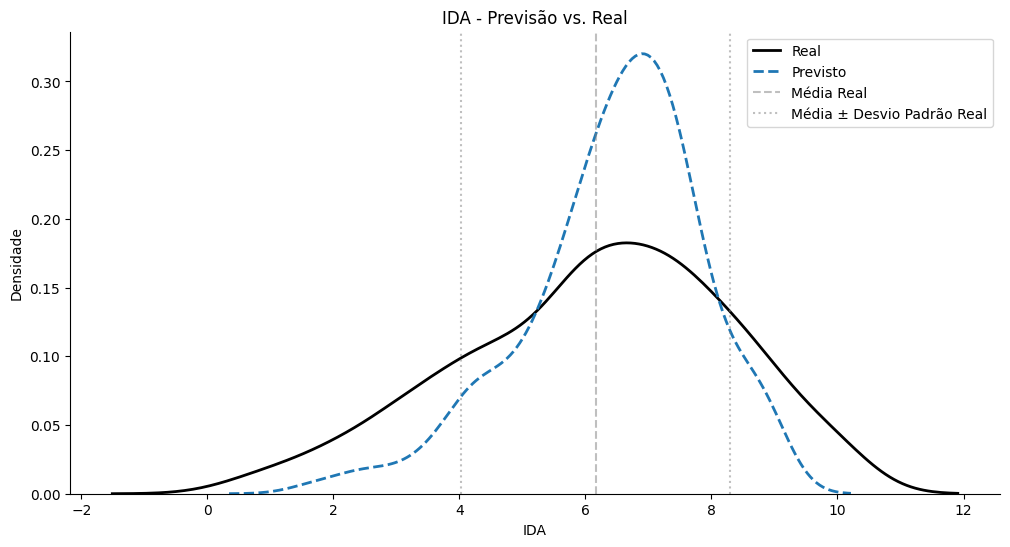

In [39]:
# Plotar previsões - densidade
plt.subplots(figsize=(12, 6))
sns.kdeplot(y_test, label='Real', linewidth=2, color='k')
sns.kdeplot(y_pred, label='Previsto', linewidth=2, linestyle='--')
# média e desvio padrão
plt.axvline(np.array(y_test).mean(), color='gray', linestyle='--', label='Média Real', alpha=0.5)
plt.axvline(np.array(y_test).mean() + np.array(y_test).std(), color='gray', linestyle=':', label='Média ± Desvio Padrão Real', alpha=0.5)
plt.axvline(np.array(y_test).mean() - np.array(y_test).std(), color='gray', linestyle=':', alpha=0.5)
plt.title('IDA - Previsão vs. Real')
plt.xlabel('IDA')
plt.ylabel('Densidade')
sns.despine()
plt.legend()
plt.show()

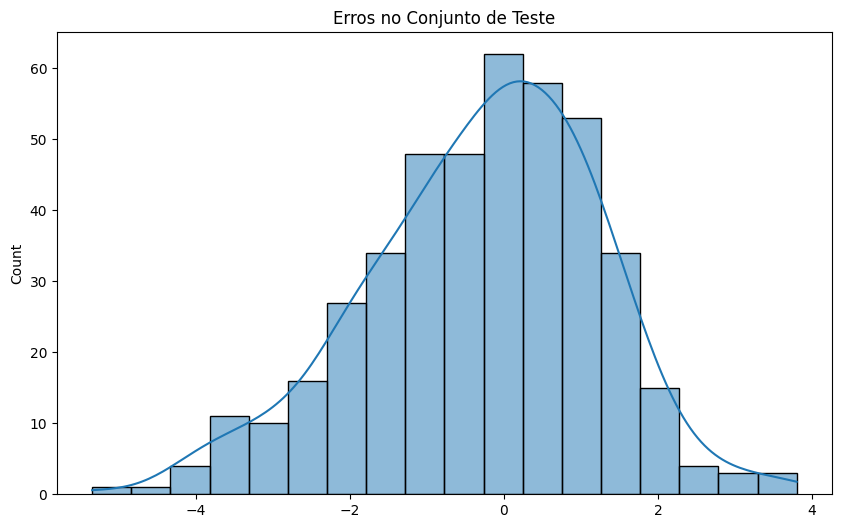

In [40]:
# Plotar erros de teste
plt.figure(figsize=(10, 6))
plt.title('Erros no Conjunto de Teste')
sns.histplot(np.array(y_test) - np.array(y_pred).flatten(), kde=True);

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


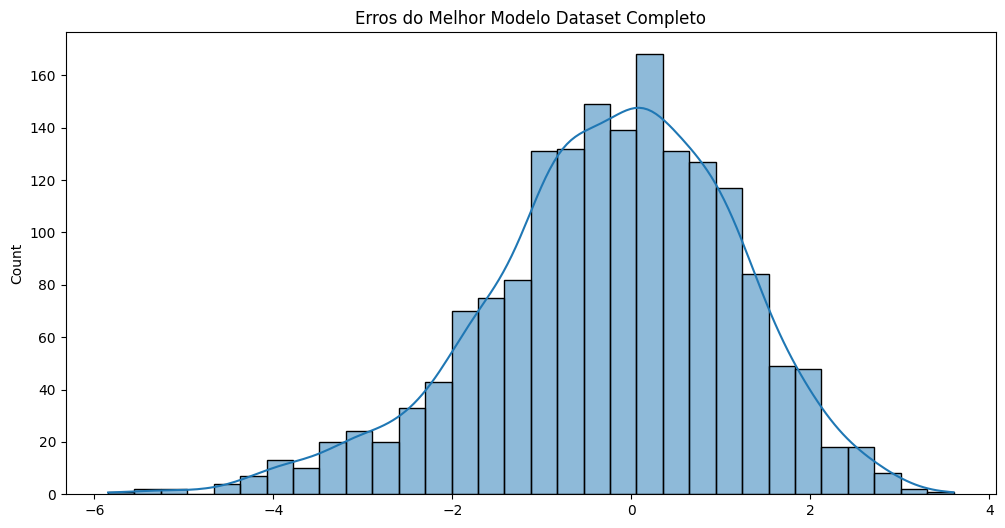

In [41]:
# Plotar erros em todo o dataset
erros = y_all - model.predict(X_all).flatten()

plt.figure(figsize=(12, 6))
plt.title('Erros do Melhor Modelo Dataset Completo')
sns.histplot(erros, kde=True);

In [42]:
X.columns

Index(['fase', 'ponto_virada', 'ano', 'bolsista', 'iaa', 'ian', 'ieg', 'ips',
       'ipp', 'ipv', 'atencao', 'destaque'],
      dtype='object')

In [43]:
preds_df = pd.DataFrame(X_all.numpy())

In [44]:
preds_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0,0.0,0.783334,0.333333,0.962963,0.7500,0.562500,0.722222,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.800000,0.333333,0.630000,0.7500,0.850000,0.770000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.900002,1.000000,0.962963,0.7500,0.604167,0.850000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.916668,1.000000,0.940000,0.5625,0.895833,0.916668,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.708333,1.000000,0.978879,0.5625,0.812500,0.750000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0.0,0.0,0.833334,0.333333,0.522696,0.5000,0.671875,0.705555,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1724,1.0,1.0,0.916668,1.000000,0.720000,0.7500,0.812500,0.900000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1725,0.0,0.0,0.800002,0.333333,0.960507,0.7500,0.604167,0.716667,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1726,0.0,1.0,0.950002,0.333333,0.940000,0.7500,0.791667,0.777778,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
preds_df = all_df.copy()

# Desfazer One-Hot Encoding de Ano e Fase
preds_df['ano'] = all_df.filter(like='ano').idxmax(axis=1)
preds_df['ano'] = preds_df['ano'].str.replace('ano_', '')
preds_df['ano'] = preds_df['ano'].astype(int)

preds_df['fase'] = all_df.filter(like='fase').idxmax(axis=1)
preds_df['fase'] = preds_df['fase'].str.replace('fase_', '')
preds_df['fase'] = preds_df['fase'].astype(int)

# Adicionar IDA real e previsto
preds_df['ida_real'] = y_all
preds_df['ida_pred'] = model.predict(X_all).flatten()
preds_df['erro'] = preds_df['ida_real'] - preds_df['ida_pred']
preds_df['erro_abs'] = preds_df['erro'].abs()

# Top 10 erros
preds_df.sort_values('erro_abs', ascending=False).head(10)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


,ponto_virada,bolsista,iaa,ian,ieg,ips,ipp,ipv,atencao,destaque,ano_2020,ano_2021,ano_2022,fase_0,fase_1,fase_2,fase_3,fase_4,fase_5,fase_6,fase_7,ida,ano,fase,ida_real,ida_pred,erro,erro_abs
718,1,1,0.950002,1.000000,0.870000,0.7500,0.812500,0.866667,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,7.347648,-5.847648,5.847648
245,0,1,0.950002,1.000000,0.890000,0.9375,0.854167,0.844444,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,6.894576,-5.394576,5.394576
313,0,1,0.750000,1.000000,0.550000,0.7500,0.812500,0.683333,False,False,True,False,False,False,False,False,True,False,False,False,False,1.166667,2020,3,1.166667,6.554531,-5.387864,5.387864
1172,0,1,0.740000,0.333333,0.750000,0.7500,0.810000,0.850000,False,False,False,True,False,False,False,True,False,False,False,False,False,1.900000,2021,2,1.900000,6.982542,-5.082542,5.082542
1813,0,0,0.741668,0.333333,0.758333,0.7500,0.604167,0.727778,False,False,False,False,True,False,True,False,False,False,False,False,False,1.250000,2022,1,1.250000,6.251471,-5.001471,5.001471
172,0,1,0.900002,1.000000,0.950000,0.7500,0.750000,0.741667,False,False,True,False,False,False,False,True,False,False,False,False,False,2.000000,2020,2,2.000000,6.629261,-4.629261,4.629261
1905,0,0,0.875001,0.333333,0.844029,0.6250,0.520833,0.708333,False,False,False,False,True,False,False,False,False,False,True,False,False,2.111111,2022,5,2.111111,6.671812,-4.560700,4.560700
381,0,1,0.800002,0.333333,0.790000,0.5000,0.468750,0.775000,False,False,True,False,False,False,False,True,False,False,False,False,False,1.250000,2020,2,1.250000,5.691528,-4.441528,4.441528
271,0,1,0.900002,0.333333,0.900000,0.5000,0.562500,0.750000,True,False,True,False,False,False,False,True,False,False,False,False,False,0.500000,2020,2,0.500000,4.884225,-4.384225,4.384225
436,0,1,0.916668,0.333333,0.520000,0.7500,0.729167,0.661111,False,False,True,False,False,False,False,False,True,False,False,False,False,1.666667,2020,3,1.666667,5.926943,-4.260277,4.260277


O modelo previu o ano de 2021 e, provavelmente por conta da Pandemia, pior o ano de 2020. Neste ano, como diversos outros estabelecimentos, a Associação Passos Mágicos teve que se adaptar ao ensino remoto, o que pode ter afetado o desempenho dos alunos, causando maior variabilidade nos dados.

In [46]:
print(f'Erro absoluto médio: {preds_df["erro_abs"].mean()}')
print()
print(preds_df.groupby('ano')['erro_abs'].mean())
print()
print(preds_df.groupby('fase')['erro_abs'].mean())

Erro absoluto médio: 1.1022334098815918

ano
2020    1.262308
2021    0.974496
2022    1.083707
Name: erro_abs, dtype: float32

fase
0    0.913480
1    1.179159
2    1.370656
3    1.083085
4    0.959997
5    1.047773
6    0.853419
7    0.730184
Name: erro_abs, dtype: float32


Apesar de parecer que o modelo previu melhor as fases 4 a 7, mas existem poucos dados dessas fases em relação às demais. A fase 0 (Alfabetização) é uma das 3 com quantidade de dados e, também, uma das com menor erro. Mais dados de alunos, principalmente nas fases 6 e 7, farão com que o modelo melhore consideravelmente:

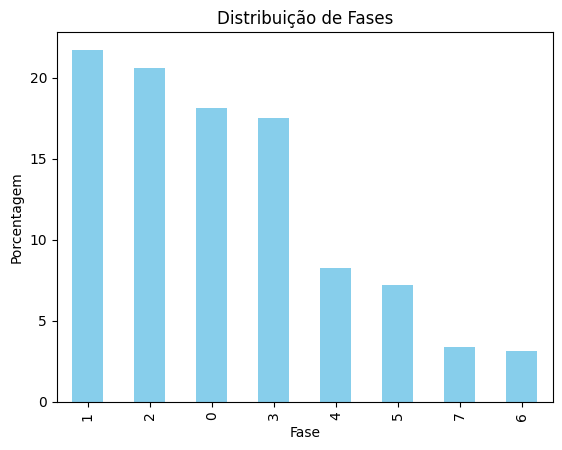

In [47]:
(df.fase.value_counts(normalize=True)*100).plot(kind='bar', color='skyblue')
plt.title('Distribuição de Fases')
plt.xlabel('Fase')
plt.ylabel('Porcentagem')
plt.show()

A distribuição dos erros de previsão em 2020 desviam mais da média do que a dos outros anos: o topo da curva é mais baixo e os erros estão mais espalhados na distribuição, o que também indica mais erros maiores.

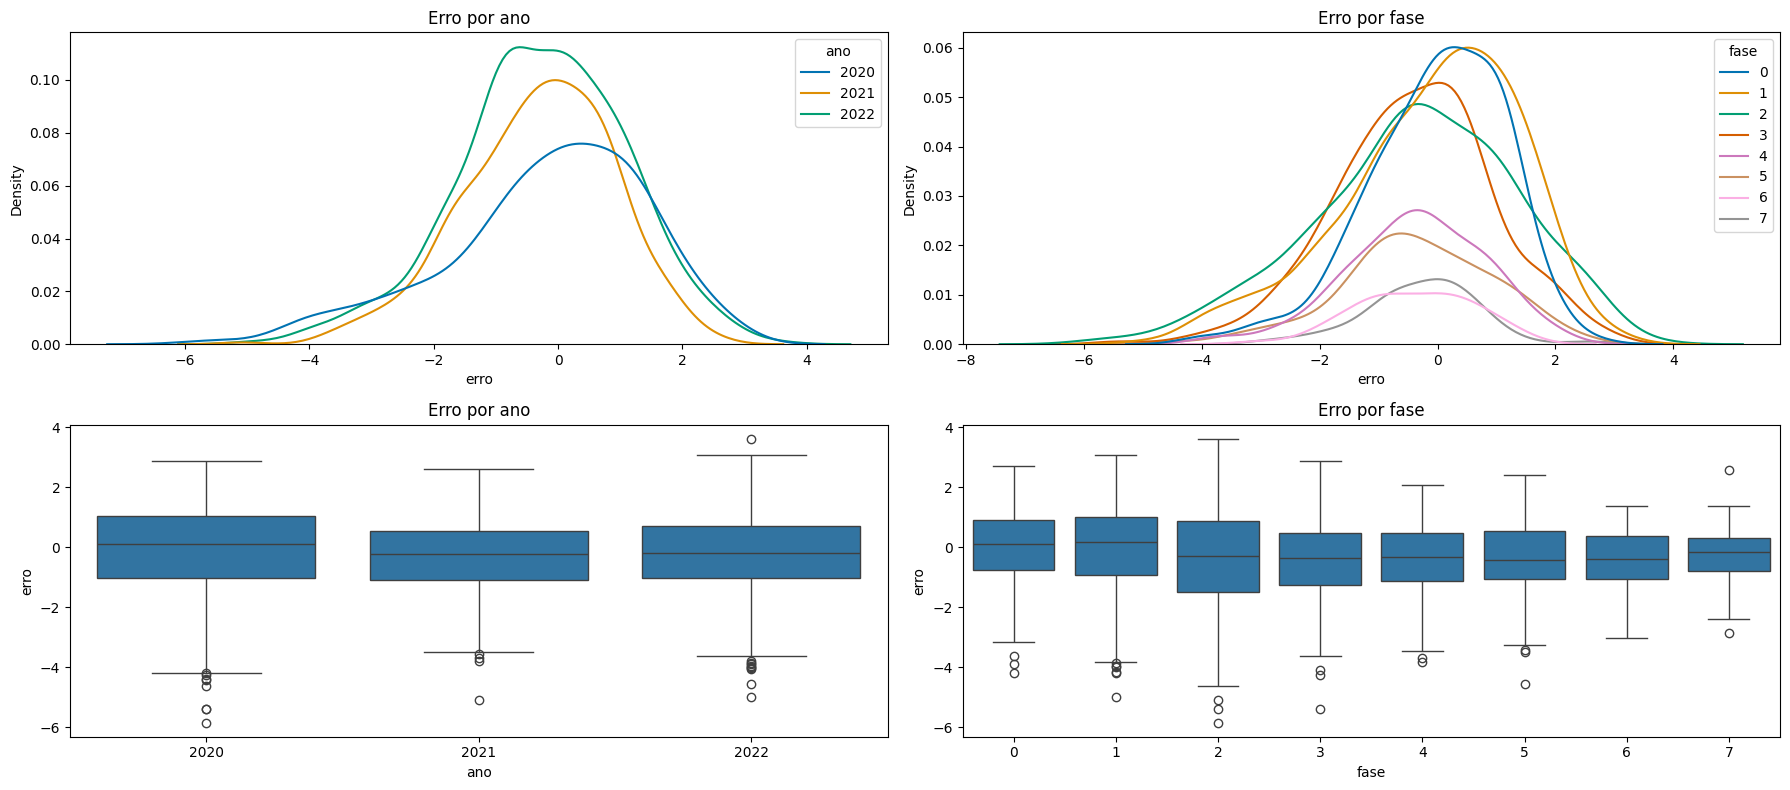

In [48]:
# Erros por Ano e Fase
fig, axs = plt.subplots(2, 2, figsize=(18, 8))

for i, col in enumerate(['ano', 'fase']):
    # Density e Boxplot
    sns.kdeplot(data=preds_df, x='erro', hue=col, palette='colorblind', ax=axs[0, i])
    sns.boxplot(data=preds_df, x=col, y='erro', ax=axs[1, i])
    axs[0, i].set_title(f'Erro por {col}')
    axs[1, i].set_title(f'Erro por {col}')
plt.tight_layout()
plt.show()

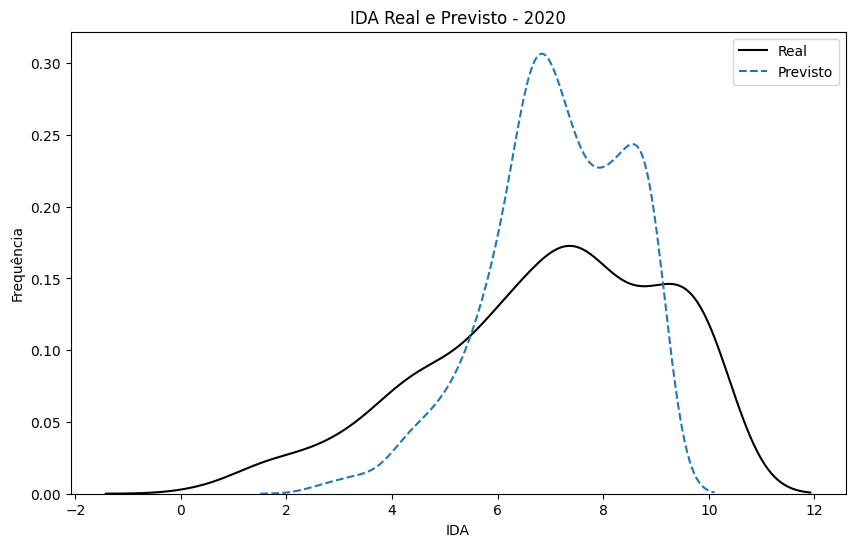

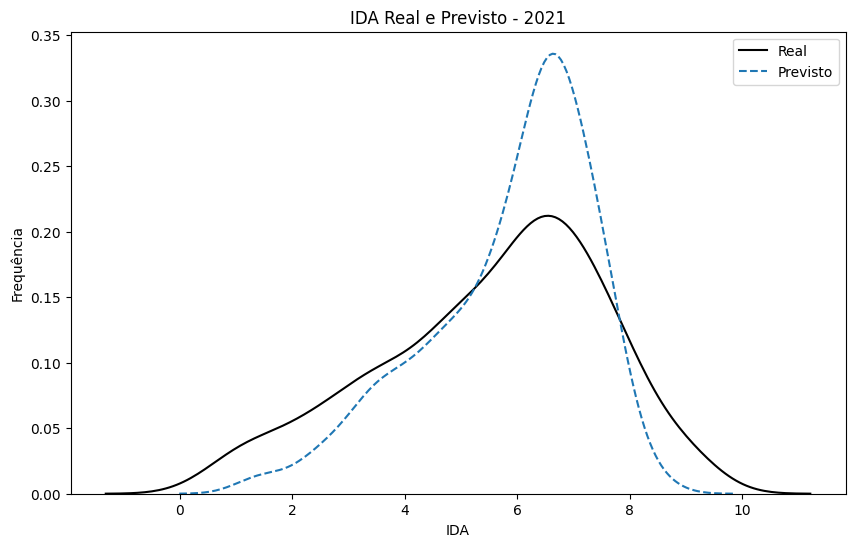

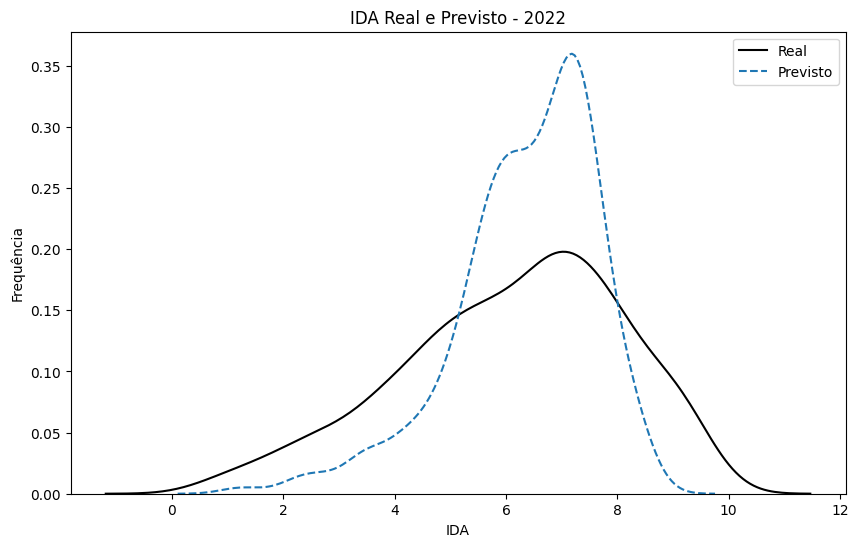

In [49]:
for i in range(2020, 2023):
    # plotar KDE por ano
    plt.figure(figsize=(10, 6))
    sns.kdeplot(preds_df[preds_df[f'ano_{i}'] == 1]['ida_real'], label='Real', color='k')
    sns.kdeplot(preds_df[preds_df[f'ano_{i}'] == 1]['ida_pred'], label='Previsto', linestyle='--')
    plt.title(f'IDA Real e Previsto - {i}')
    plt.xlabel('IDA')
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()

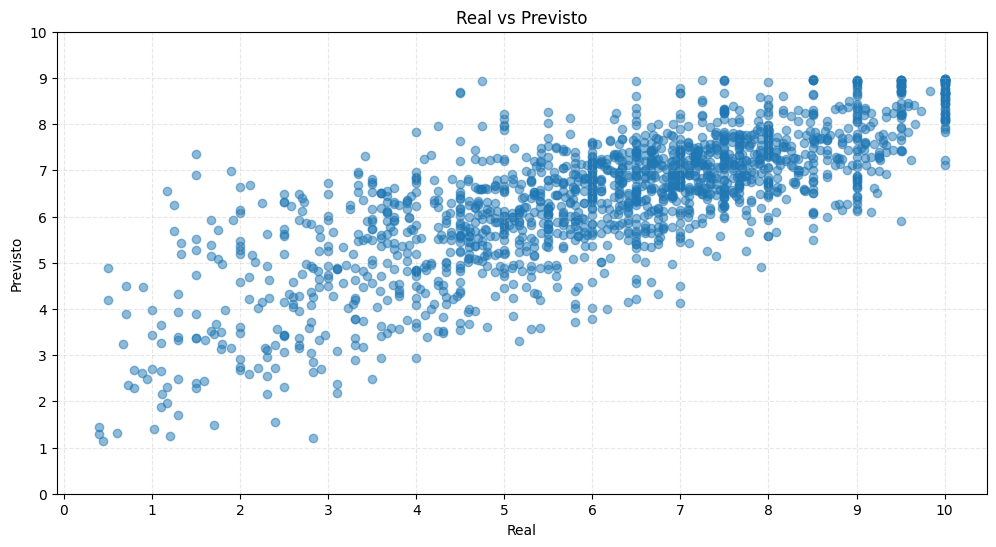

In [50]:
# Scatterplot de IDA Real e Previsto
plt.figure(figsize=(12, 6))
plt.scatter(preds_df['ida_real'], preds_df['ida_pred'], alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto')
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.show()

In [51]:
outliers_std = preds_df[preds_df['erro_abs'] > mae + preds_df['erro_abs'].std()]

print('Erros Outliers pelo Desvio Padrão:', outliers_std.shape[0]/preds_df.shape[0] * 100, '%')

# Ordenar por erro médio
outliers_std.sort_values('erro_abs', ascending=False).head(10)

Erros Outliers pelo Desvio Padrão: 12.5 %


,ponto_virada,bolsista,iaa,ian,ieg,ips,ipp,ipv,atencao,destaque,ano_2020,ano_2021,ano_2022,fase_0,fase_1,fase_2,fase_3,fase_4,fase_5,fase_6,fase_7,ida,ano,fase,ida_real,ida_pred,erro,erro_abs
718,1,1,0.950002,1.000000,0.870000,0.7500,0.812500,0.866667,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,7.347648,-5.847648,5.847648
245,0,1,0.950002,1.000000,0.890000,0.9375,0.854167,0.844444,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,6.894576,-5.394576,5.394576
313,0,1,0.750000,1.000000,0.550000,0.7500,0.812500,0.683333,False,False,True,False,False,False,False,False,True,False,False,False,False,1.166667,2020,3,1.166667,6.554531,-5.387864,5.387864
1172,0,1,0.740000,0.333333,0.750000,0.7500,0.810000,0.850000,False,False,False,True,False,False,False,True,False,False,False,False,False,1.900000,2021,2,1.900000,6.982542,-5.082542,5.082542
1813,0,0,0.741668,0.333333,0.758333,0.7500,0.604167,0.727778,False,False,False,False,True,False,True,False,False,False,False,False,False,1.250000,2022,1,1.250000,6.251471,-5.001471,5.001471
172,0,1,0.900002,1.000000,0.950000,0.7500,0.750000,0.741667,False,False,True,False,False,False,False,True,False,False,False,False,False,2.000000,2020,2,2.000000,6.629261,-4.629261,4.629261
1905,0,0,0.875001,0.333333,0.844029,0.6250,0.520833,0.708333,False,False,False,False,True,False,False,False,False,False,True,False,False,2.111111,2022,5,2.111111,6.671812,-4.560700,4.560700
381,0,1,0.800002,0.333333,0.790000,0.5000,0.468750,0.775000,False,False,True,False,False,False,False,True,False,False,False,False,False,1.250000,2020,2,1.250000,5.691528,-4.441528,4.441528
271,0,1,0.900002,0.333333,0.900000,0.5000,0.562500,0.750000,True,False,True,False,False,False,False,True,False,False,False,False,False,0.500000,2020,2,0.500000,4.884225,-4.384225,4.384225
436,0,1,0.916668,0.333333,0.520000,0.7500,0.729167,0.661111,False,False,True,False,False,False,False,False,True,False,False,False,False,1.666667,2020,3,1.666667,5.926943,-4.260277,4.260277


In [52]:
# outliers com iqr
q1 = preds_df['erro_abs'].quantile(0.25)
q3 = preds_df['erro_abs'].quantile(0.75)
iqr = q3 - q1

outliers_iqr = preds_df[(preds_df['erro_abs'] < q1 - 1.5*iqr) | (preds_df['erro_abs'] > q3 + 1.5*iqr)]

print('Erros Outliers IQR:', outliers_iqr.shape[0]/preds_df.shape[0] * 100, '%')

# Ordenar por erro médio
outliers_iqr.sort_values('erro_abs', ascending=False).head(10)

Erros Outliers IQR: 3.356481481481482 %


,ponto_virada,bolsista,iaa,ian,ieg,ips,ipp,ipv,atencao,destaque,ano_2020,ano_2021,ano_2022,fase_0,fase_1,fase_2,fase_3,fase_4,fase_5,fase_6,fase_7,ida,ano,fase,ida_real,ida_pred,erro,erro_abs
718,1,1,0.950002,1.000000,0.870000,0.7500,0.812500,0.866667,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,7.347648,-5.847648,5.847648
245,0,1,0.950002,1.000000,0.890000,0.9375,0.854167,0.844444,False,False,True,False,False,False,False,True,False,False,False,False,False,1.500000,2020,2,1.500000,6.894576,-5.394576,5.394576
313,0,1,0.750000,1.000000,0.550000,0.7500,0.812500,0.683333,False,False,True,False,False,False,False,False,True,False,False,False,False,1.166667,2020,3,1.166667,6.554531,-5.387864,5.387864
1172,0,1,0.740000,0.333333,0.750000,0.7500,0.810000,0.850000,False,False,False,True,False,False,False,True,False,False,False,False,False,1.900000,2021,2,1.900000,6.982542,-5.082542,5.082542
1813,0,0,0.741668,0.333333,0.758333,0.7500,0.604167,0.727778,False,False,False,False,True,False,True,False,False,False,False,False,False,1.250000,2022,1,1.250000,6.251471,-5.001471,5.001471
172,0,1,0.900002,1.000000,0.950000,0.7500,0.750000,0.741667,False,False,True,False,False,False,False,True,False,False,False,False,False,2.000000,2020,2,2.000000,6.629261,-4.629261,4.629261
1905,0,0,0.875001,0.333333,0.844029,0.6250,0.520833,0.708333,False,False,False,False,True,False,False,False,False,False,True,False,False,2.111111,2022,5,2.111111,6.671812,-4.560700,4.560700
381,0,1,0.800002,0.333333,0.790000,0.5000,0.468750,0.775000,False,False,True,False,False,False,False,True,False,False,False,False,False,1.250000,2020,2,1.250000,5.691528,-4.441528,4.441528
271,0,1,0.900002,0.333333,0.900000,0.5000,0.562500,0.750000,True,False,True,False,False,False,False,True,False,False,False,False,False,0.500000,2020,2,0.500000,4.884225,-4.384225,4.384225
436,0,1,0.916668,0.333333,0.520000,0.7500,0.729167,0.661111,False,False,True,False,False,False,False,False,True,False,False,False,False,1.666667,2020,3,1.666667,5.926943,-4.260277,4.260277


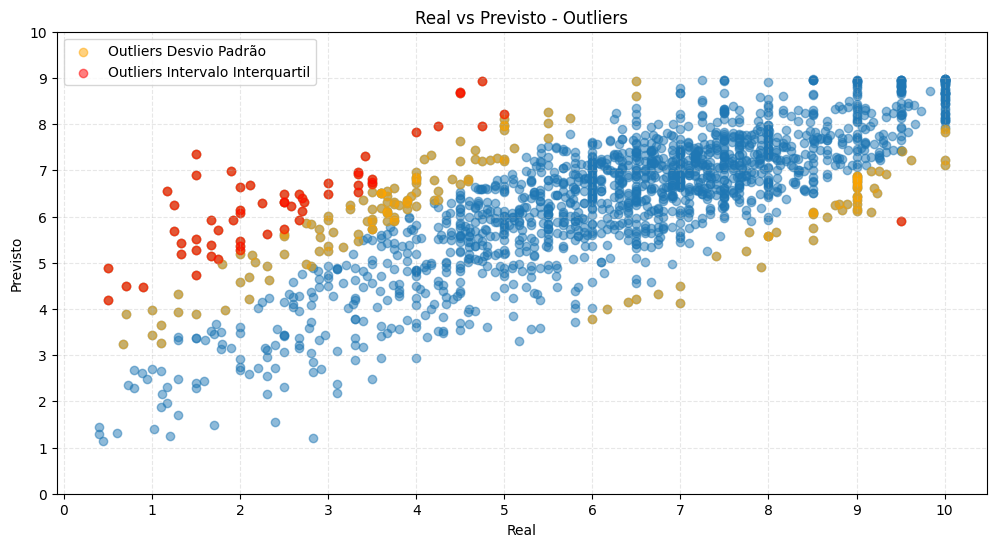

In [53]:
# plotar erros
plt.figure(figsize=(12, 6))
plt.scatter(preds_df['ida_real'], preds_df['ida_pred'], alpha=0.5)
plt.scatter(outliers_std['ida_real'], outliers_std['ida_pred'], color='orange', alpha=0.5, label='Outliers Desvio Padrão')
plt.scatter(outliers_iqr['ida_real'], outliers_iqr['ida_pred'], color='red', alpha=0.5, label='Outliers Intervalo Interquartil')
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Real vs Previsto - Outliers')
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()

Os erros mais discrepantes se concentram mais nas bordas da distribuição, o que indica que o modelo pode ser melhorado com mais dados sobre alunos com desempenho acadêmico superior ou inferior à média.